# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Neste trabalho, exploramos o desafio da classificação de texto em múltiplas categorias, um problema conhecido como Classificação Multi Classe. Focamos especificamente na análise de textos em língua portuguesa brasileira, utilizando um conjunto de dados composto por notícias jornalísticas do site da CNN Brasil. <br>
A tarefa envolve a atribuição de cada texto a uma categoria específica, dentre várias possíveis. O objetivo é utilizar três bibiotecas de python para fazer o pré-processamento desses textos: spaCy, NLTK e Gensim e analisar suas diferenças. <br>
Ao longo deste projeto, também exploraremos diferentes técnicas de pré-processamento de texto, bem tecnicas de análise distintas para melhor analisarmos as bibliotecas e os textos. O foco está na compreensão das categorias de notícias e na construção de textos limpos que podem tornar a classificação de  novos textos mais precisas. <br>

## Bibliotecas
As bibliotecas principais do python utilizadas neste trabalho estão a seguir.

In [1]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Dataset
O dataset é composto de matérias jornalisticas postadas dia 4 de novembro de 2023 no site da CNN Brasil de 11 categorias diferentes(entretenimento, política, esportes e outros). Devido ao tamanho do arquivo, foi decidido apenas utlizar um dataset. <br>
O arquivo se encontra no formato parquet. Parquet é um formato de arquivo em coluna com otimizações para acelerar as consultas considerado mais rápido que os formato mais populares json e csv.<br>
Antes de fazer o pré-processamento dos textos jornalisticos é necessário verificar sua integridade. Em caso de haver qualquer irregularidade, é feito uma limpeza nele. Primeiramente, verifica-se com a função describe do pandas as seguintes informações:<br>
+ linha count: número de linhas eu contêm em cada coluna
+ linha unique: número de valores/textos unicos em cada coluna
+ linha top: mostra a primeira linha do dataset 
+ linha freq: frequência de uma informação em cada coluna

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.describe()

,titulo,texto,link,resumo,categoria,data_hora
count,3877,3877,3877,3877,3877,3877
unique,3877,3705,3619,3574,11,3522
top,"Veja a trajetória de Fernando Diniz, em busca ...",,https://www.cnnbrasil.com.br/economia/mercado-...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-08 12:14:27
freq,1,40,7,9,960,7


Pode ser visto na tabela acima, na linha unique, que há 11 categorias diferentes no dataset assim como há 3877 linhas. Porém pode ser observado que das 3877 linhas há apenas 3705 textos na coluna texto, ou seja, há informações faltando. Então, é necessário retirar as linhas que não contêm informações úteis ao trabalho. Isso pode ser feito com removendo linhas vazias com dropna e apply.

In [5]:
# Remove linhas que contêm NaN na coluna texto
df = df.dropna(subset=['texto'])

# Remover linhas com linhas vazias
df= df[df['texto'].apply(lambda x: len(x) > 0)]

In [6]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento
Com as linhas vazias retiradas do dataframe, verificamos a quantidade de texto para cada categoria com value_counts. Essa etapa é importante, pois a diferença entre a quantidade de textos para cada categoria pode afetar o resultado final da predição. <br>
A etapa de balancemaneto é importante para garantir que o modelo de aprendizado de máquina não seja tendencioso em relação a uma classe específica devido ao desequilíbrio na distribuição das classes. <br>

In [7]:
df['categoria'].value_counts()

esportes           920
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

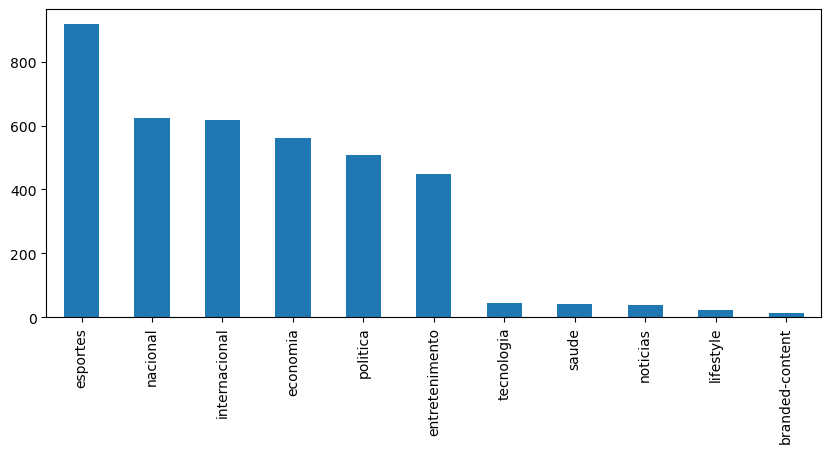

In [8]:
# Visualizando a diferença de textos por categoria
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

Pelo gráfico acima percebemos que há uma grande diferença entre as categorias. Poderiamos injetar outro dataset para balancear, porém decidimos retirá-las para não afetar os resultados.

In [9]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [10]:
df = df[~df['categoria'].isin(indice_linha_remover)]

Com as categorias de menor números retiradas temos os seguintes valores. <br>

In [11]:
df['categoria'].value_counts()

esportes          920
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

Os valores acima ainda continuam muito diferentes entre si. Então, usamos a técnica de undersampling para balancear os dados.<br> Undersampling(subamostragem) envolve a redução da quantidade de dados da classe majoritária, de modo que equilibre o número entre ela e as classes menores. Então, será utilizado a categoria que tem o menor número de textos como o alvo do corte. <br>

In [12]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [13]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

Com o balanceamento feito, ainda precisamos resetar o index.

In [14]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Série A: veja jogos e risco de rebaixamento do...,"O Campeonato Brasileiro inicia, nesta terça-fe...",https://www.cnnbrasil.com.br/esportes/serie-a-...,Vasco e Corinthians abrem rodada 36 do Brasile...,esportes,2023-11-28 03:21:15
1,Gols de Romero renderam renderam dez pontos ao...,O atacante Ángel Romero vive um momento bastan...,https://www.cnnbrasil.com.br/esportes/gols-de-...,Paraguaio retomou espaço com Mano Menezes e se...,esportes,2023-11-29 17:56:08
2,Entenda por que a Copa 2026 atrasa anúncio de ...,"A Copa América de 2024 será nos EUA, de 20 de ...",https://www.cnnbrasil.com.br/esportes/entenda-...,Confusão sobre patrocínios nas arenas dos EUA ...,esportes,2023-11-08 21:35:40
3,Veja qual foi a dieta de Ramon Dino para o Mr....,Ramon Dino foi o 2º colocado do Mr. Olympia 20...,https://www.cnnbrasil.com.br/esportes/veja-qua...,Atleta do Acre já participou de três edições d...,esportes,2023-11-07 14:31:06
4,Palmeiras recebe o América-MG para ampliar lid...,Palmeiras e América-MG fazem duelo de opostos ...,https://www.cnnbrasil.com.br/esportes/palmeira...,Verdão está empatado em pontos com o Flamengo ...,esportes,2023-11-29 14:15:48


Com tudo feito, copiamos o dataframe duas vezes. Assim, temos um dataframe para cada biblioteca e não correremos o risco de interferência.

In [15]:
df_balanceado2 = df_balanceado.copy()
df_balanceado3 = df_balanceado.copy()

In [16]:
# pega coluna
text = df_balanceado['texto'] # para NLTK
text2 = df_balanceado2['texto'] # para spaCy
text3 = df_balanceado3['texto'] # para Gensim
len(text)

2700

In [17]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento
O pré-processamento é uma etapa fundamental que visa preparar os dados textuais para análise e processamento por algoritmos de aprendizado de máquina e técnicas de mineração de texto. Essa etapa desempenha um papel crucial na garantia da qualidade e eficácia das análises realizadas. <br>
Nesta seção os textos do dataset serão limpos utilizando três bibliotecas diferentes: NLTK, gensim e spaCy. Essas três bibliotecas são para processamento de linguagem natural. A comparação entre elas será feita e discutidas na seção análise.<br>
Para cada uma das bibliotecas foi feito: 
+ Normalização
+ Tokenização
+ Remoção de stop words
+ Limpeza de dados <br>

Como algumas palavras possuem acento em português, a remoção de stop words foi feita antes da normalização e limpeza de dados. Assim diminui as chances de que palavras inuteis não sejam retiradas do texto.

### NLTK
O NLTK é uma biblioteca popular de Python projetada para trabalhar com processamento de linguagem natural (PLN). Ele fornece uma variedade de ferramentas e recursos para tarefas como tokenização, stemming, lematização, análise sintática, marcação de partes do discurso, análise semântica e muito mais. <br>
Foram utilizadas funções da biblioteca para a tokenização e remoção de stopwords. <br>
Primeiro o texto é colocado em letras minúsculas e tokenizado.

In [18]:
# Passa textos para minuscula.
for i in range(len(text)):
    text[i] = text[i].lower()

In [19]:
# tokenização
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [20]:
print(token_text[0])

['o', 'campeonato', 'brasileiro', 'inicia', ',', 'nesta', 'terça-feira', '(', '28', ')', ',', 'a', 'rodada', 'de', 'número', '36.', 'até', 'aqui', ',', 'são', 'nove', 'clubes', 'que', ',', 'matematicamente', ',', 'ainda', 'estão', 'na', 'luta', 'contra', 'o', 'rebaixamento', '.', 'os', 'números', 'são', 'do', 'departamento', 'de', 'matemática', 'da', 'ufmg', '.', 'são', 'nove', 'times', 'com', 'riscos', 'matemática', 'de', 'rebaixamento', '.', 'são', 'paulo', '(', '47', 'pontos', ')', 'e', 'internacional', '(', '46', 'pontos', ')', 'somam', 'menos', 'de', '1', '%', 'de', 'chances', 'e', 'foram', 'desconsiderados', '.', 'abaixo', ',', 'a', 'lista', 'com', 'os', 'jogos', 'de', 'cada', 'time', 'ainda', 'na', 'disputa', 'e', 'a', 'chance', 'de', 'rebaixamento', 'ao', 'final', 'da', 'rodada', '.', 'leia', 'mais', 'o', 'jogo', 'que', 'encerrou', 'a', '35ª', 'rodada', 'do', 'brasileirão', 'foi', 'a', 'vitória', 'do', 'cruzeiro', 'por', '1', 'a', '0', ',', 'nesta', 'segunda-feira', '(', '27', 

Em seguida, fazemos o download das stopwords em português e as retiramos.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [23]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [24]:
print(token_text[0])

['campeonato', 'brasileiro', 'inicia', ',', 'nesta', 'terça-feira', '(', '28', ')', ',', 'rodada', 'número', '36.', 'aqui', ',', 'nove', 'clubes', ',', 'matematicamente', ',', 'ainda', 'luta', 'contra', 'rebaixamento', '.', 'números', 'departamento', 'matemática', 'ufmg', '.', 'nove', 'times', 'riscos', 'matemática', 'rebaixamento', '.', 'paulo', '(', '47', 'pontos', ')', 'internacional', '(', '46', 'pontos', ')', 'somam', 'menos', '1', '%', 'chances', 'desconsiderados', '.', 'abaixo', ',', 'lista', 'jogos', 'cada', 'time', 'ainda', 'disputa', 'chance', 'rebaixamento', 'final', 'rodada', '.', 'leia', 'jogo', 'encerrou', '35ª', 'rodada', 'brasileirão', 'vitória', 'cruzeiro', '1', '0', ',', 'nesta', 'segunda-feira', '(', '27', ')', ',', 'estádio', 'serrinha', ',', 'goiânia', '.', 'gol', 'robert', ',', '50', 'minutos', 'segundo', 'tempo', ',', 'fez', 'despencar', 'chances', 'rebaixamento', 'time', 'estrelado', 'torneio', '.', 'final', 'disputa', ',', 'dois', 'clubes', 'lista', 'jogarão', 

Temos agora que retornar os tokens a serem texto para retirarmos os acentos, pontuações e números. A razão de não termos tirado os acentos das palavras antes é porque as stopwords do NLTK possuem acento, sem eles no texto as palavras desnecessárias não serão eliminadas.

In [25]:
for i in range(len(token_text)):
    token_text[i] = ' '.join(token_text[i])
print(token_text[0])

campeonato brasileiro inicia , nesta terça-feira ( 28 ) , rodada número 36. aqui , nove clubes , matematicamente , ainda luta contra rebaixamento . números departamento matemática ufmg . nove times riscos matemática rebaixamento . paulo ( 47 pontos ) internacional ( 46 pontos ) somam menos 1 % chances desconsiderados . abaixo , lista jogos cada time ainda disputa chance rebaixamento final rodada . leia jogo encerrou 35ª rodada brasileirão vitória cruzeiro 1 0 , nesta segunda-feira ( 27 ) , estádio serrinha , goiânia . gol robert , 50 minutos segundo tempo , fez despencar chances rebaixamento time estrelado torneio . final disputa , dois clubes lista jogarão série b 2024. juntarão rebaixados coritiba américa-mg. rodada 36 : bragantino , 20h30 , quinta-feira ( 30 ) , nabi abi chedid , bragança paulista ( sp ) ; rodada 37 : goiás , 18h30 , domingo ( 3 ) , serrinha , goiânia ( go ) ; rodada 38 : santos , 21h30 , quarta-feira ( 6 ) , vila belmiro , santos ( sp ) ; rodada 36 : athletico pr ,

Usamos unidecode e ragex para retirar acentos, números e pontuações. Depois retornamos a tokenização.

In [26]:
from unidecode import unidecode

for i in range(len(token_text)):
    token_text[i] = unidecode(token_text[i])

In [27]:
for i in range(len(token_text)):
    token_text[i] = re.sub(r'[^a-zA-Z\s]', "" ,token_text[i])

In [28]:
t_text = []

for j in token_text:
    t_text.append(nltk.word_tokenize(j))
    
token_text = t_text

In [29]:
df_balanceado['texto'] = token_text

### spaCy
SpaCy é outra biblioteca para PLN. Seu foco é em eficiência. Como foi o caso da biblioteca nltk, a retirada de acentos, pontuações e número foi feita depois da remoção de stop words. Pois as stop words do spaCy possuem acentos.<br>

In [30]:
for i in range(len(text2)):
    text2[i] = text2[i].lower()

O spaCy possui uma biblioteca para português, que precisa ser baixada e carregada antes de aplicar suas funções. O padrão é sempre inglês caso a lingua não seja definida. <br>
A função nlp() transforma qualquer texto em um dicionário.<br>

In [31]:
nlp = spacy.load('pt_core_news_sm')

doc = []

for j in text2:
    temp = nlp(j)
    doc.append(temp)

In [32]:
token_text2 = []

for i in range(len(text2)):
    temp = [token.text for token in doc[i] if not token.is_space]
    token_text2.append(temp)

In [33]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop = STOP_WORDS
#print(stop)

In [34]:
token2 = []
for i in token_text2:
    temp = []
    for token in i:
        if token not in stop:
            temp.append(token)
    token2.append(temp)
print(token2[0])

['campeonato', 'brasileiro', 'inicia', ',', 'terça-feira', '(', '28', ')', ',', 'rodada', '36', '.', ',', 'clubes', ',', 'matematicamente', ',', 'luta', 'rebaixamento', '.', 'departamento', 'matemática', 'ufmg', '.', 'times', 'riscos', 'matemática', 'rebaixamento', '.', 'paulo', '(', '47', ')', 'internacional', '(', '46', ')', 'somam', '1', '%', 'chances', 'desconsiderados', '.', 'abaixo', ',', 'lista', 'jogos', 'time', 'disputa', 'chance', 'rebaixamento', 'rodada', '.', 'leia', 'jogo', 'encerrou', '35ª', 'rodada', 'brasileirão', 'vitória', 'cruzeiro', '1', '0', ',', 'segunda-feira', '(', '27', ')', ',', 'estádio', 'serrinha', ',', 'goiânia', '.', 'gol', 'robert', ',', '50', 'minutos', ',', 'despencar', 'chances', 'rebaixamento', 'time', 'estrelado', 'torneio', '.', 'disputa', ',', 'clubes', 'lista', 'jogarão', 'série', 'b', '2024', '.', 'juntarão', 'rebaixados', 'coritiba', 'américa-mg', '.', 'rodada', '36', ':', 'bragantino', ',', '20h30', ',', 'quinta-feira', '(', '30', ')', ',', 'n

In [35]:
token22 = []
for i in token2:
    token22.append(' '.join(i))
token22[0]

'campeonato brasileiro inicia , terça-feira ( 28 ) , rodada 36 . , clubes , matematicamente , luta rebaixamento . departamento matemática ufmg . times riscos matemática rebaixamento . paulo ( 47 ) internacional ( 46 ) somam 1 % chances desconsiderados . abaixo , lista jogos time disputa chance rebaixamento rodada . leia jogo encerrou 35ª rodada brasileirão vitória cruzeiro 1 0 , segunda-feira ( 27 ) , estádio serrinha , goiânia . gol robert , 50 minutos , despencar chances rebaixamento time estrelado torneio . disputa , clubes lista jogarão série b 2024 . juntarão rebaixados coritiba américa-mg . rodada 36 : bragantino , 20h30 , quinta-feira ( 30 ) , nabi abi chedid , bragança paulista ( sp);rodada 37 : goiás , 18h30 , domingo ( 3 ) , serrinha , goiânia ( go);rodada 38 : santos , 21h30 , quarta-feira ( 6 ) , vila belmiro , santos ( sp ) ; rodada 36 : athletico pr , 20h , quinta-feira ( 30 ) , mineirão , belo horizonte ( mg);rodada 37 : botafogo , 18h30 , domingo ( 3 ) , nilton santos ,

In [36]:
from unidecode import unidecode

for i in range(len(token22)):
    token22[i] = unidecode(token22[i])

In [37]:
for i in range(len(token22)):
   token22[i] = re.sub(r'[^a-zA-Z\s]', "" ,token22[i])

In [38]:
nlp = spacy.load('pt_core_news_sm')

doct = []

for j in token22:
    temp = nlp(j)
    doct.append(temp)
    
token_text22 = []

for i in range(len(token22)):
    temp = [token.text for token in doct[i] if not token.is_space]
    token_text22.append(temp)

print(token_text22[0])

['campeonato', 'brasileiro', 'inicia', 'tercafeira', 'rodada', 'clubes', 'matematicamente', 'luta', 'rebaixamento', 'departamento', 'matematica', 'ufmg', 'times', 'riscos', 'matematica', 'rebaixamento', 'paulo', 'internacional', 'somam', 'chances', 'desconsiderados', 'abaixo', 'lista', 'jogos', 'time', 'disputa', 'chance', 'rebaixamento', 'rodada', 'leia', 'jogo', 'encerrou', 'a', 'rodada', 'brasileirao', 'vitoria', 'cruzeiro', 'segundafeira', 'estadio', 'serrinha', 'goiania', 'gol', 'robert', 'minutos', 'despencar', 'chances', 'rebaixamento', 'time', 'estrelado', 'torneio', 'disputa', 'clubes', 'lista', 'jogarao', 'serie', 'b', 'juntarao', 'rebaixados', 'coritiba', 'americamg', 'rodada', 'bragantino', 'h', 'quintafeira', 'nabi', 'abi', 'chedid', 'braganca', 'paulista', 'sprodada', 'goias', 'h', 'domingo', 'serrinha', 'goiania', 'gorodada', 'santos', 'h', 'quartafeira', 'vila', 'belmiro', 'santos', 'sp', 'rodada', 'athletico', 'pr', 'h', 'quintafeira', 'mineirao', 'belo', 'horizonte', 

In [39]:
token2 = token_text22

In [40]:
df_balanceado2['texto'] = token2

### Gensim
Gensim é uma biblioteca open-source para modelagem de tópicos, PLN e indexação semântica de documentos. Ela oferece implementações de algoritmos e sua faciliade de uso a torna muito utilizada.<br>

In [41]:
from gensim.utils import simple_preprocess
from gensim.utils import tokenize

In [42]:
for i in range(len(text3)):
   text3[i] = re.sub(r'[^a-zA-Z\s]', "" ,text3[i])

A função simple preprocess é uma ferramenta conveniente para pré-processamento básico de texto. Ela realiza uma série de operações simples, como tokenização, conversão para minúsculas, remoção de pontuação e filtragem de tokens com base em comprimento mínimo e máximo. Porém a remoção de pontuação foi colocada para falso porque ele retira as letras que contêm acentos.

In [43]:
for i in range(len(text3)):
    text3[i] = simple_preprocess(text3[i], deacc=False, min_len=3)

Diferente da outras bibliotecas, gensim não possui stopwords para portguês, apenas para inglês. Então é utilizado uma lista de stopwords no lugar.

In [44]:
stopwords = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

#print(stopwords)

In [45]:
token3 = []
for i in text3:
    temp = []
    for token in i:
        if token not in stopwords:
            temp.append(token)
    token3.append(temp)
print(token3[0])

['campeonato', 'brasileiro', 'inicia', 'terafeira', 'rodada', 'nmero', 'clubes', 'matematicamente', 'esto', 'luta', 'rebaixamento', 'nmeros', 'departamento', 'matemtica', 'ufmg', 'times', 'riscos', 'matemtica', 'rebaixamento', 'paulo', 'internacional', 'somam', 'chances', 'desconsiderados', 'abaixo', 'lista', 'jogos', 'time', 'disputa', 'chance', 'rebaixamento', 'rodada', 'leia', 'jogo', 'encerrou', 'rodada', 'brasileiro', 'vitria', 'cruzeiro', 'segundafeira', 'estdio', 'serrinha', 'goinia', 'gol', 'robert', 'minutos', 'tempo', 'despencar', 'chances', 'rebaixamento', 'time', 'estrelado', 'torneio', 'disputa', 'clubes', 'lista', 'jogaro', 'srie', 'juntaro', 'rebaixados', 'coritiba', 'amricamg', 'rodada', 'bragantino', 'quintafeira', 'nabi', 'abi', 'chedid', 'bragana', 'paulista', 'sprodada', 'gois', 'domingo', 'serrinha', 'goinia', 'gorodada', 'santos', 'quartafeira', 'vila', 'belmiro', 'santos', 'rodada', 'athletico', 'quintafeira', 'mineiro', 'belo', 'horizonte', 'mgrodada', 'botafogo

In [46]:
df_balanceado3['texto'] = token3

## Análises
Nesta seção estão as análises de cada uma das bibliotecas. É utilizado em cada uma delas LDA model do gensim para prever os 6 tópicos, uma nuvem de palavras do wordcloud para saber quais palavras aparecem mais nos textos e contagem de frequência de palavras. No caso de contaem de frequência de apalvras apenas utilizamos o primeiro texto.

### NLTK

In [47]:
# Contagem de frequência de palavras usando NLTK 

from nltk.probability import FreqDist

freq_dist = FreqDist(token_text[0])
# Exibição da frequência de cada palavra
#for token, freq in freq_dist.items():
#    print(token, freq)

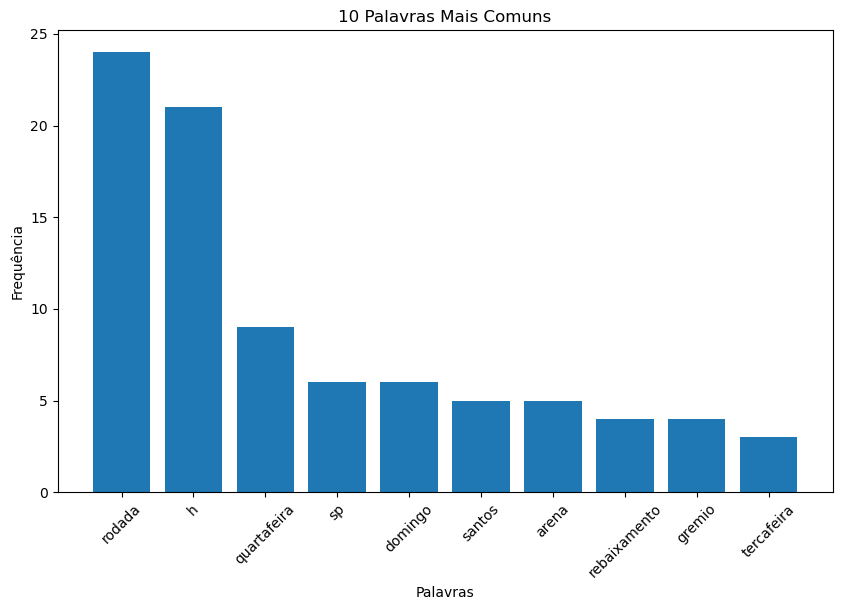

In [48]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = freq_dist.most_common(10)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

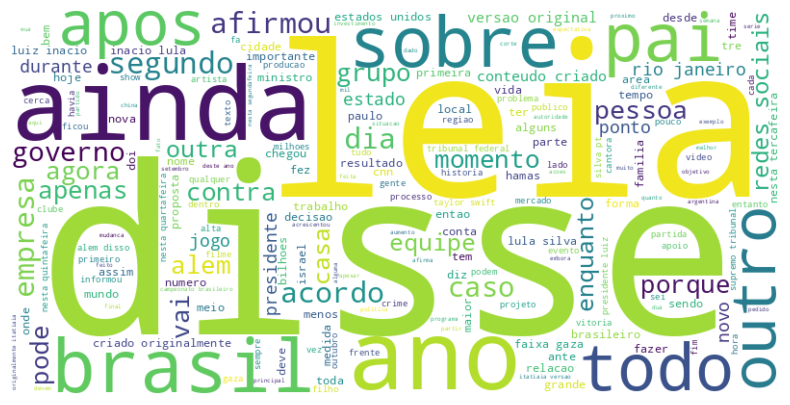

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token_text])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [50]:
from gensim import corpora

dict_NLTK = corpora.Dictionary(token_text) 
corpus_NLTK = [dict_NLTK.doc2bow(text) for text in token_text]

In [51]:
from gensim.models import LdaModel

ldamodel_NLTK = LdaModel(corpus_NLTK, num_topics=6, id2word=dict_NLTK, passes=50)

for topic in ldamodel_NLTK.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.007*"cantora" + 0.007*"show" + 0.007*"taylor" + 0.006*"brasil" + 0.006*"swift"')
Tópicos:  (1, '0.010*"disse" + 0.007*"israel" + 0.006*"gaza" + 0.005*"sobre" + 0.005*"hamas"')
Tópicos:  (2, '0.006*"contra" + 0.005*"policia" + 0.005*"leia" + 0.004*"pontos" + 0.004*"a"')
Tópicos:  (3, '0.005*"energia" + 0.005*"segundo" + 0.005*"brasil" + 0.005*"milei" + 0.005*"paulo"')
Tópicos:  (4, '0.008*"r" + 0.006*"sobre" + 0.006*"ano" + 0.005*"bilhoes" + 0.004*"governo"')
Tópicos:  (5, '0.013*"presidente" + 0.010*"lula" + 0.008*"federal" + 0.008*"ministro" + 0.007*"stf"')


### spaCy

In [52]:
from spacy.attrs import ORTH # Contagem de frequência de palavras usando Spacy

doc_sp = nlp(" ".join(token2[0]))

count_dict = doc_sp.count_by(ORTH)

In [53]:
sorted_counts = sorted(count_dict.items(), key=lambda item: item[1], reverse=True)

# 10 mais frequentes
top_10_frequent_words = sorted_counts[:10]

# Print
for word, count in top_10_frequent_words:
    print(nlp.vocab.strings[word], count)

h 21
rodada 10
quartafeira 9
domingo 6
santos 5
arena 5
rebaixamento 4
gremio 4
tercafeira 3
paulo 3


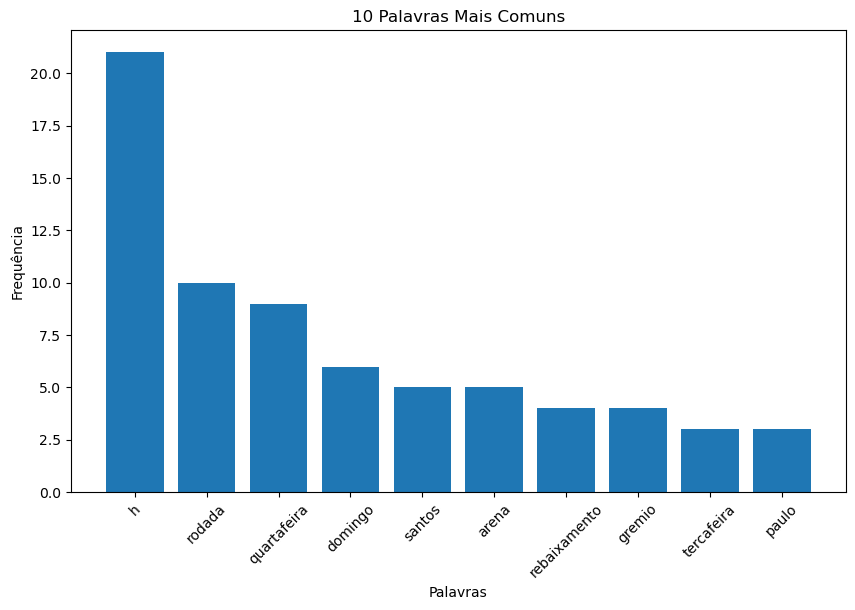

In [54]:
palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in top_10_frequent_words:
    palavras.append(nlp.vocab.strings[word])
    contagens.append(count)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

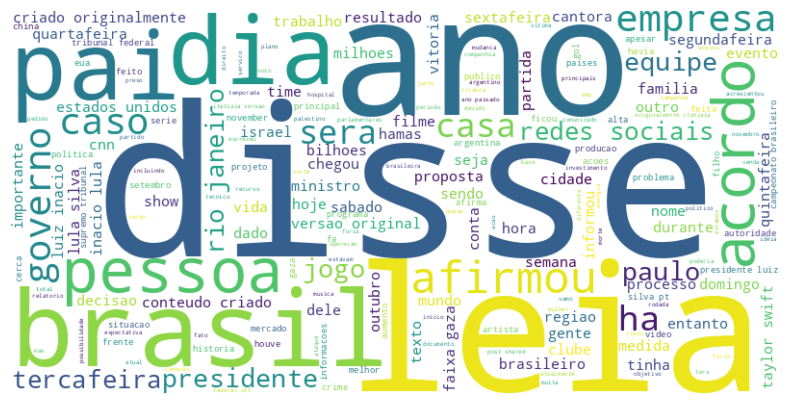

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token2])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [56]:
from gensim import corpora

dict_S = corpora.Dictionary(token2) 
corpus_S = [dict_S.doc2bow(text) for text in token2]

In [57]:
from gensim.models import LdaModel

ldamodel_S = LdaModel(corpus_S, num_topics=6, id2word=dict_S, passes=50)
 
for topic in ldamodel_S.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.014*"presidente" + 0.010*"governo" + 0.009*"lula" + 0.007*"ministro" + 0.007*"federal"')
Tópicos:  (1, '0.008*"anos" + 0.006*"familia" + 0.005*"disse" + 0.005*"vida" + 0.005*"redes"')
Tópicos:  (2, '0.014*"israel" + 0.013*"disse" + 0.013*"gaza" + 0.011*"hamas" + 0.005*"pessoas"')
Tópicos:  (3, '0.007*"r" + 0.005*"h" + 0.005*"paulo" + 0.005*"ano" + 0.004*"energia"')
Tópicos:  (4, '0.008*"taylor" + 0.008*"show" + 0.007*"cantora" + 0.007*"brasil" + 0.006*"swift"')
Tópicos:  (5, '0.010*"policia" + 0.005*"caso" + 0.005*"federal" + 0.005*"disse" + 0.004*"anos"')


### Gensim

In [58]:
from gensim import corpora

dictionary = corpora.Dictionary(token3) 
corpus = [dictionary.doc2bow(text) for text in token3]
print(corpus[1])

[(7, 1), (15, 2), (16, 1), (23, 1), (24, 4), (27, 1), (45, 1), (47, 1), (52, 1), (59, 1), (72, 1), (73, 1), (75, 1), (76, 1), (104, 1), (105, 1), (107, 1), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (116, 1), (117, 1), (118, 3), (119, 1), (120, 1), (121, 1), (122, 1), (123, 1), (124, 1), (125, 1), (126, 1), (127, 3), (128, 1), (129, 1), (130, 1), (131, 2), (132, 1), (133, 1), (134, 2), (135, 1), (136, 2), (137, 2), (138, 1), (139, 1), (140, 1), (141, 1), (142, 1), (143, 2), (144, 1), (145, 1), (146, 1), (147, 1), (148, 4), (149, 1), (150, 1), (151, 1), (152, 1), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1)]


In [59]:
mapping = {v: k for k, v in dictionary.token2id.items()}
ttt = [[(mapping[i[0]], i[1]) for i in item] for item in corpus]
print(ttt[0])

[('abaixo', 1), ('abi', 2), ('alegre', 2), ('amrica', 2), ('amricamg', 1), ('arena', 5), ('athletico', 2), ('atltico', 1), ('baixada', 1), ('barodada', 1), ('belmiro', 3), ('belo', 3), ('botafogo', 1), ('bragana', 2), ('bragantino', 2), ('brasileiro', 2), ('campeonato', 1), ('castelo', 1), ('cerodada', 1), ('chance', 1), ('chances', 2), ('chedid', 2), ('clubes', 2), ('contedo', 1), ('corinthians', 1), ('coritiba', 2), ('couto', 1), ('criado', 1), ('cruzeiro', 1), ('curitiba', 2), ('departamento', 1), ('desconsiderados', 1), ('despencar', 1), ('disputa', 2), ('domingo', 6), ('encerrou', 1), ('estdio', 1), ('esto', 1), ('estrelado', 1), ('fluminense', 1), ('fonte', 2), ('fortaleza', 3), ('gama', 1), ('goinia', 3), ('gois', 1), ('gol', 1), ('gorodada', 1), ('grmio', 4), ('horizonte', 3), ('independncia', 1), ('inicia', 1), ('internacional', 2), ('itatiaia', 1), ('janeiro', 3), ('janurio', 2), ('jogaro', 1), ('jogo', 1), ('jogos', 1), ('juntaro', 1), ('leia', 1), ('lista', 2), ('luta', 1),

In [60]:
sorted_ttt = sorted(ttt[0], key=lambda x: x[1], reverse=True)

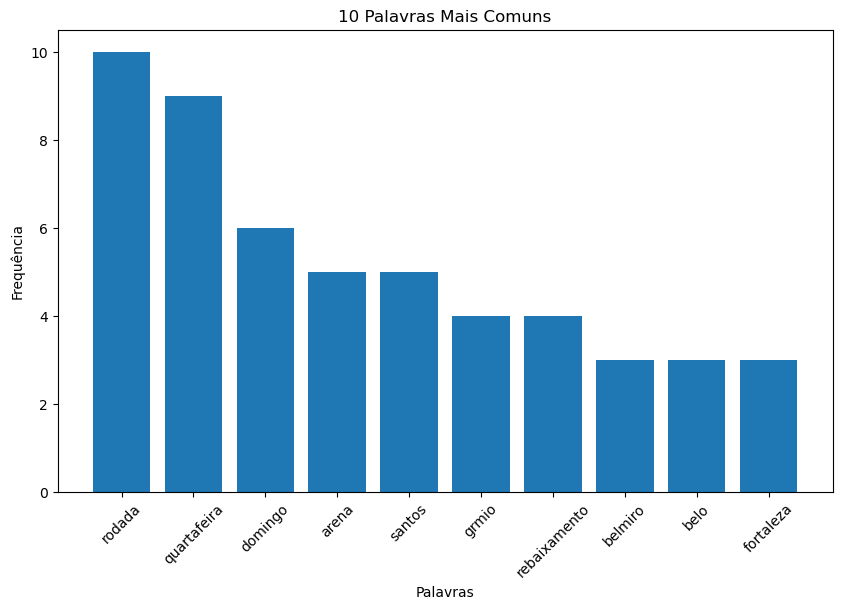

In [61]:
first_ten_elements = sorted_ttt[:10]

palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in first_ten_elements:
    palavras.append(word)
    contagens.append(count)


# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

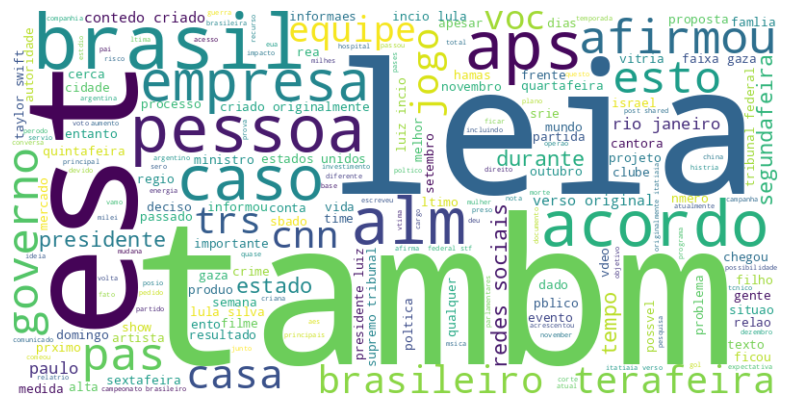

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token3])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [63]:
from gensim.models import LdaModel

ldamodel = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=50)

for topic in ldamodel.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.009*"israel" + 0.009*"gaza" + 0.007*"hamas" + 0.005*"leia" + 0.005*"tambm"')
Tópicos:  (1, '0.009*"show" + 0.008*"taylor" + 0.008*"cantora" + 0.008*"brasil" + 0.007*"swift"')
Tópicos:  (2, '0.006*"tambm" + 0.005*"paulo" + 0.005*"polcia" + 0.005*"caso" + 0.005*"energia"')
Tópicos:  (3, '0.007*"gonet" + 0.004*"est" + 0.004*"pessoas" + 0.003*"vida" + 0.003*"ento"')
Tópicos:  (4, '0.007*"filme" + 0.006*"tambm" + 0.005*"est" + 0.004*"srie" + 0.004*"mundo"')
Tópicos:  (5, '0.013*"presidente" + 0.010*"governo" + 0.010*"lula" + 0.007*"ministro" + 0.007*"federal"')


### Comparação
A frequência de palavras no primeiro texto entre as bibliotecas forem quase o mesmo. Entretanto, pode-se perceber que alguma palavras não foram retiradas. A bibioteca gensim teve o melhor resutado porque em sua função simple preprocess pode-se colocar um minimo e um máximo de caracteres. Para as bibliotecas NLTK e spaCy é necessário verificar os textos e retirar palavras especiais que não são parte da remoção de stop words. <br>
Analisando o gráfico em nuvem de palavras (todos os textos foram analisados juntos), pode-se observar que nem todas as palavras communs foram retiradas como também, está, leia entre outras, especialmente aquelas que são siglas. No gráfico do gensim pode-se ver que ele retira letras que possuem acentos, prejudicando a retirada de stop words. <br>
Para o modelo de LDA, houve problemas para achar os tópicos na biblioteca gensim devido as palavras que não foram retiradas, causando uma confusão na definição dos tópicos. Além disso, nas três bibliotecas, houve uma certa uma certa confusão entre as categorias nacional e politica.<br>
Outras técnicas de anáise foram cogitadas porém elas não deram informações revelantes para a análise dos textos processados, então foram descartadas (como desvio padrão).<br> 